以iris数据集（iris）为例进行分析。iris以鸢尾花的特征作为数据来源，数据集包含150个数据集，分为3类，每类50个数据，每个数据包含4个属性，是在数据挖掘、数据分类中非常常用的测试集、训练集。为了便于理解，我们这里主要用后两个属性（花瓣的长度和宽度）来进行分类。目前 spark.ml 中支持二分类和多分类，我们将分别从“用二项逻辑斯蒂回归来解决二分类问题”、“用多项逻辑斯蒂回归来解决二分类问题”、“用多项逻辑斯蒂回归来解决多分类问题”三个方面进行分析
## 二项逻辑斯蒂回归解决 二分类 问题

In [5]:
!hadoop fs -cat /user/yanbin/data/iris.txt|head -n5

5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5.0,3.6,1.4,0.2,Iris-setosa


In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkConf,SparkContext
from pyspark.ml import Pipeline,PipelineModel
from pyspark.ml.linalg import Vector,Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml.classification import BinaryLogisticRegressionSummary
from pyspark.ml.feature import StringIndexer,IndexToString,HashingTF,Tokenizer,VectorIndexer
from pyspark.sql import Row
conf = SparkConf().setAppName('logist Regession')\
                  .setMaster('local')
spark = SparkSession.builder\
        .config(conf=conf)\
        .enableHiveSupport()\
        .getOrCreate()
sc = spark.sparkContext

path = 'data/iris.txt'

rawdata = sc.textFile(path).map(lambda line:line.split(","))\
          .map(lambda x:Row(Vectors.dense(float(x[0]),float(x[1]),float(x[2]),float(x[3])),x[4]))
rawDf = spark.createDataFrame(rawdata,["features","label"])
df=rawDf.filter("label!='Iris-setosa'")

labelInder = StringIndexer(inputCol='label',outputCol='indexedLabel').fit(df)
featureIndex = VectorIndexer(inputCol='features',outputCol='indexedFeatures').fit(df)
(traningDf,testDf) = df.randomSplit(seed=40,weights=[0.7,0.3])
lr = LogisticRegression(featuresCol='indexedFeatures',labelCol='indexedLabel',\
                        maxIter=30,regParam=0.3,elasticNetParam=0.8)
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel',labels=labelInder.labels)
lrPipeline = Pipeline().setStages([labelInder,featureIndex,lr,labelConverter])
lrPipelineModel = lrPipeline.fit(traningDf)
lrPredictions = lrPipelineModel.transform(testDf)

(Iris-versicolor, Iris-versicolor --> prob=[4.9,2.4,3.3,1.0], predicted Label=[0.716325732145,0.283674267855]
(Iris-versicolor, Iris-versicolor --> prob=[5.1,2.5,3.0,1.1], predicted Label=[0.689500241555,0.310499758445]
(Iris-versicolor, Iris-versicolor --> prob=[5.5,2.4,3.8,1.1], predicted Label=[0.685134580757,0.314865419243]
(Iris-versicolor, Iris-versicolor --> prob=[5.5,2.6,4.4,1.2], predicted Label=[0.651602888724,0.348397111276]
(Iris-versicolor, Iris-versicolor --> prob=[5.6,2.5,3.9,1.1], predicted Label=[0.684586544749,0.315413455251]
('Test Error = ', 0.040262725779967035)
Coefficients:  [[ 0.          0.          0.02539243  0.13614217]] 
Intercept:  [-1.01010337977] 
numClasses:  2 
numFeatures:  4
[0.692346967089961, 0.6897655700581456, 0.6868996195107941, 0.6811549066615707, 0.6767302758174719, 0.675095414866011, 0.6736463495757629, 0.6729071372292478, 0.6722989791632441, 0.6720654075435648, 0.6717562431190895, 0.67157205869176, 0.6712736878512384, 0.6700741906180208, 0.6

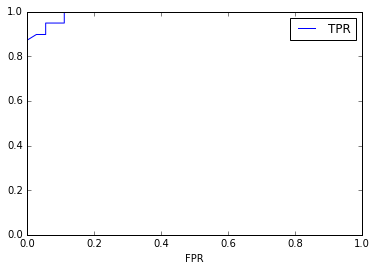

In [20]:
%matplotlib inline
result = lrPredictions.select("predictedLabel", "label", "features", "probability").rdd\
.map(lambda x:("(%s, %s --> prob=%s, predicted Label=%s") %(x.predictedLabel,x.label,x.features,x.probability))\
.take(5)
for i in result:
    print i
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',predictionCol='prediction')
lrAccuracy = evaluator.evaluate(lrPredictions)
print ('Test Error = ',1-lrAccuracy)
lrModel = lrPipelineModel.stages[2]
print "Coefficients: " , lrModel.coefficientMatrix.toArray(),"\n"\
        "Intercept: ",lrModel.interceptVector,"\n"\
        "numClasses: ",lrModel.numClasses,"\n"\
        "numFeatures: ",lrModel.numFeatures
trainingSummary = lrModel.summary
objectiveHistory = trainingSummary.objectiveHistory
print objectiveHistory
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.

import matplotlib.pyplot as plt
pD=trainingSummary.roc.toPandas()
# plt.plot(pD.ix[:,0],pD.ix[:,1])
pD_FPR=pD.set_index('FPR')
pD_FPR.plot()
plt.legend(loc='best')
FDf=trainingSummary.fMeasureByThreshold.sort('threshold')
maxFMeasure =FDf.select(max('F-Measure').alias('maxFMeasure')).head().maxFMeasure
print 'maxFMeasure: ',maxFMeasure
FDf=FDf.withColumnRenamed('F-Measure','F1')
# FDf.select(FDf.F1.cast(FloatType())).show()
# FDf.createTempView('F1Table2')
bestThreshold = FDf.where((-0.00001<(FDf.F1-maxFMeasure)) & ((FDf.F1-maxFMeasure)<0.0001)).head()['threshold']
print 'bestThreshold: ',bestThreshold
lr.setThreshold(bestThreshold)
# pDf=trainingSummary.precisionByThreshold
# rDf=trainingSummary.recallByThreshold
# rDf=rDf.withColumnRenamed('threshold','threshold1')
# f=rDf.join(pDf,pDf.threshold==rDf.threshold1,'left')
# f.select(f.threshold,(2/((1.0/f.recall)+(1.0/f.precision))).alias('F1')).sort('threshold').show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))





## 用多项逻辑斯蒂回归解决 二分类 问题

In [16]:
mlr = LogisticRegression(featuresCol='indexedFeatures',labelCol='indexedLabel',\
                         maxIter=30,regParam=0.3,elasticNetParam=0.8,family='multinomial')
mlrPipeline = Pipeline().setStages([labelInder,featureIndex,mlr,labelConverter])
mlrPipelineModel = mlrPipeline.fit(traningDf)
mlrPredictions = mlrPipelineModel.transform(testDf)
result2 =mlrPredictions.select("predictedLabel", "label", "features", "probability").rdd\
.map(lambda x:("(%s, %s --> prob=%s, predicted Label=%s") %(x.predictedLabel,x.label,x.features,x.probability)).take(5)
for i in result2:
    print i
mEvaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',predictionCol='prediction')
mlrAccuracy = evaluator.evaluate(mlrPredictions)
mlrModel = mlrPipelineModel.stages[2]
print "Coefficients: " , mlrModel.coefficientMatrix.toArray(),"\n"\
        "Intercept: ",mlrModel.interceptVector,"\n"\
        "numClasses: ",mlrModel.numClasses,"\n"\
        "numFeatures: ",mlrModel.numFeatures
mlrAccuracy = mEvaluator.evaluate(mlrPredictions)
print ('Test Error = ',1-mlrAccuracy)


(Iris-virginica, Iris-virginica --> prob=[4.9,2.5,4.5,1.7], predicted Label=[0.000263882990519,0.488791815578,0.510944301431]
(Iris-versicolor, Iris-versicolor --> prob=[5.0,2.0,3.5,1.0], predicted Label=[0.00038333159631,0.709402862587,0.290213805817]
(Iris-versicolor, Iris-versicolor --> prob=[5.2,2.7,3.9,1.4], predicted Label=[0.00031853199882,0.58728450905,0.412396958951]
(Iris-versicolor, Iris-versicolor --> prob=[5.5,2.6,4.4,1.2], predicted Label=[0.000353891918354,0.649211840228,0.350434267854]
(Iris-versicolor, Iris-versicolor --> prob=[5.6,2.5,3.9,1.1], predicted Label=[0.000370557233623,0.678789039518,0.320840403249]
Coefficients:  [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [ -1.67334915e-02   0.00000000e+00  -2.76990261e-04  -6.98083553e-04]
 [  0.00000000e+00   0.00000000e+00   2.73033386e-04   1.34109179e+00]] 
Intercept:  [-4.29867961528,3.3099338471,0.988745768181] 
numClasses:  3 
numFeatures:  4
('Test Error = ', 0.02948869172778079)


## 用多项逻辑斯蒂回归解决 多分类 问题

In [21]:
tmTrainingDf,tmTestDf = rawDf.randomSplit(seed=40,weights=[0.7,0.3])
labelInder = StringIndexer(inputCol='label',outputCol='indexedLabel').fit(rawDf)
featureIndex = VectorIndexer(inputCol='features',outputCol='indexedFeatures').fit(rawDf)
mlr = LogisticRegression(featuresCol='indexedFeatures',labelCol='indexedLabel',\
                         maxIter=50,regParam=0.1,elasticNetParam=0.8,family='multinomial')
labelConverter = IndexToString(inputCol='prediction',outputCol='predictedLabel',labels=labelInder.labels)
threeMlrPipeline = Pipeline().setStages([labelInder,featureIndex,mlr,labelConverter])
threeMlrPipelineModel = threeMlrPipeline.fit(tmTrainingDf)
threeMlrPredictions = threeMlrPipelineModel.transform(tmTestDf)
result3 = threeMlrPredictions.select("predictedLabel", "label", "features", "probability").rdd\
.map(lambda x:("(%s, %s --> prob=%s, predicted Label=%s") %(x.predictedLabel,x.label,x.features,x.probability)).take(5)
for i in result3:
    print i
tmEvaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',predictionCol='prediction')
tmlrAccuracy = tmEvaluator.evaluate(threeMlrPredictions)
mlrModel = threeMlrPipelineModel.stages[2]
print "Coefficients: " , mlrModel.coefficientMatrix.toArray(),"\n"\
        "Intercept: ",mlrModel.interceptVector,"\n"\
        "numClasses: ",mlrModel.numClasses,"\n"\
        "numFeatures: ",mlrModel.numFeatures
tmlrAccuracy = tmEvaluator.evaluate(threeMlrPredictions)
print ('Test Error = ',1-tmlrAccuracy)


(Iris-setosa, Iris-setosa --> prob=[4.3,3.0,1.1,0.1], predicted Label=[0.817644066583,0.164184473642,0.0181714597753]
(Iris-setosa, Iris-setosa --> prob=[4.4,2.9,1.4,0.2], predicted Label=[0.757512213685,0.214837411808,0.027650374507]
(Iris-setosa, Iris-setosa --> prob=[4.4,3.2,1.3,0.2], predicted Label=[0.819984472039,0.159647744478,0.0203677834835]
(Iris-setosa, Iris-setosa --> prob=[4.5,2.3,1.3,0.3], predicted Label=[0.607315165928,0.343697706718,0.0489871273544]
(Iris-setosa, Iris-setosa --> prob=[4.6,3.1,1.5,0.2], predicted Label=[0.7844636836,0.190673874774,0.0248624416259]
Coefficients:  [[ -6.87426251e-02   1.08026940e+00  -4.96472954e-01  -8.06254642e-01]
 [  0.00000000e+00  -8.09784903e-03   0.00000000e+00   0.00000000e+00]
 [  1.06988175e-03   0.00000000e+00   1.12024889e-01   1.17991501e+00]] 
Intercept:  [0.332199605741,1.06952586337,-1.40172546911] 
numClasses:  3 
numFeatures:  4
('Test Error = ', 0.04347826086956519)
